In [1]:
# import library
import numpy as np
import pandas as pd
import xgboost as xgb
import gc
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the data
train = pd.read_csv('./data/train_2016_v2.csv')
prop = pd.read_csv('./data/properties_2016.csv')
sample = pd.read_csv('./data/sample_submission.csv')

In [3]:
# Data Preprocessing
def process_data(train, prop):

  # Convert float64 columns to float32 to reduce memory usage
  for c, dtype in zip(prop.columns, prop.dtypes):
    if dtype == np.float64:
        prop[c] = prop[c].astype(np.float32)

  # Merge training data with property data
  df_train = train.merge(prop, how='left', on='parcelid')

  # Prepare features (X) and target variables (y) for training
  # Drop unnecessary columns
  x_train = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1)
  y_train = df_train['logerror'].values

  # Store column names for later use
  train_columns = x_train.columns

  # Convert object (string) columns to boolean
  for c in x_train.dtypes[x_train.dtypes == object].index.values:
    x_train[c] = (x_train[c] == True)

  # Create training and validation dataset
  split = 80000
  x_train, y_train, x_valid, y_valid = x_train[:split], y_train[:split], x_train[split:], y_train[split:]

  return x_train, y_train, x_valid, y_valid, train_columns

x_train, y_train, x_valid, y_valid, train_columns = process_data(train, prop)

# Build XGBoost DMatrix objects for efficient processing
d_train = xgb.DMatrix(x_train, label = y_train)
d_valid = xgb.DMatrix(x_valid, label = y_valid)

In [4]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.8 MB/s eta 0:00:00


In [10]:
import optuna

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

# Define the objective function
def objective(trial):
    params = {
        'objective': 'reg:linear',
        'eval_metric': 'mae',
        'eta': trial.suggest_float('eta', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True)
    }

    # Train the model
    model = xgb.train(params, d_train, num_boost_round=1000, evals=watchlist,
                      early_stopping_rounds=100, verbose_eval=False)

    # Return the best validation MAE
    val_mae = model.best_score
    return val_mae

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, timeout=600)

# Print the best parameters
print(f"Best Parameters: {study.best_params}")

[I 2024-08-09 16:16:47,711] A new study created in memory with name: no-name-1d793790-0cf7-428a-98e8-db09df712673
[I 2024-08-09 16:16:54,441] Trial 0 finished with value: 0.06629797653655392 and parameters: {'eta': 0.07733579918541657, 'max_depth': 3, 'subsample': 0.6143365009871308, 'colsample_bytree': 0.9872429311445753, 'n_estimators': 387, 'lambda': 5.910399209895078e-07, 'alpha': 0.9996564175432738}. Best is trial 0 with value: 0.06629797653655392.
[I 2024-08-09 16:16:56,188] Trial 1 finished with value: 0.06631480756078659 and parameters: {'eta': 0.018670351089281233, 'max_depth': 3, 'subsample': 0.7456365145616369, 'colsample_bytree': 0.9065288858373961, 'n_estimators': 844, 'lambda': 0.004582320255231644, 'alpha': 4.734523681325461e-05}. Best is trial 0 with value: 0.06629797653655392.
[I 2024-08-09 16:16:58,282] Trial 2 finished with value: 0.06638166105791636 and parameters: {'eta': 0.07675185918222203, 'max_depth': 6, 'subsample': 0.8313784915421027, 'colsample_bytree': 0.85

Best Parameters: {'eta': 0.08333862152228264, 'max_depth': 4, 'subsample': 0.9070355288196612, 'colsample_bytree': 0.6858202221370895, 'n_estimators': 737, 'lambda': 1.0505818295001094e-05, 'alpha': 5.6283984330024535e-08}


In [12]:
# Train Model
params = study.best_params
params['objective'] = 'reg:linear'
params['eval_metric'] = 'mae'

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
clf = xgb.train(params, d_train, 10000, watchlist,
                early_stopping_rounds=100, verbose_eval=10)

[0]	train-mae:0.06852	valid-mae:0.06647
[10]	train-mae:0.06806	valid-mae:0.06623
[20]	train-mae:0.06790	valid-mae:0.06637
[30]	train-mae:0.06778	valid-mae:0.06651
[40]	train-mae:0.06771	valid-mae:0.06660
[50]	train-mae:0.06766	valid-mae:0.06668
[60]	train-mae:0.06759	valid-mae:0.06676
[70]	train-mae:0.06754	valid-mae:0.06686
[80]	train-mae:0.06747	valid-mae:0.06690
[90]	train-mae:0.06738	valid-mae:0.06695
[100]	train-mae:0.06732	valid-mae:0.06699
[109]	train-mae:0.06727	valid-mae:0.06703


In [8]:
# Run on test data

# Merge sample data with property data
sample['parcelid'] = sample['ParcelId']
df_test = sample.merge(prop, on='parcelid', how = 'left')

# Convert object (string) columns to boolean
x_test = df_test[train_columns]
for c in x_test.dtypes[x_test.dtypes == object].index.values:
    x_test[c] = (x_test[c] == True)

# Generate prediction
d_test = xgb.DMatrix(x_test)
p_test = clf.predict(d_test)

In [9]:
# Create submission file
sub = pd.read_csv('./data/sample_submission.csv')

def output_csv(sub, p_test):
    for c in sub.columns[sub.columns != 'ParcelId']:
        sub[c] = p_test

    sub.to_csv('xgb.csv', index=False, float_format='%.4f')

output_csv(sub, p_test)

In [13]:
import optuna.visualization as vis

# Optimization history plot
opt_history_fig = vis.plot_optimization_history(study)
opt_history_fig.show()

# Parameter importance plot
param_importance_fig = vis.plot_param_importances(study)
param_importance_fig.show()

# Slice plot
slice_fig = vis.plot_slice(study)
slice_fig.show()

# Slice plot
slice_fig = vis.plot_slice(study)
slice_fig.show()

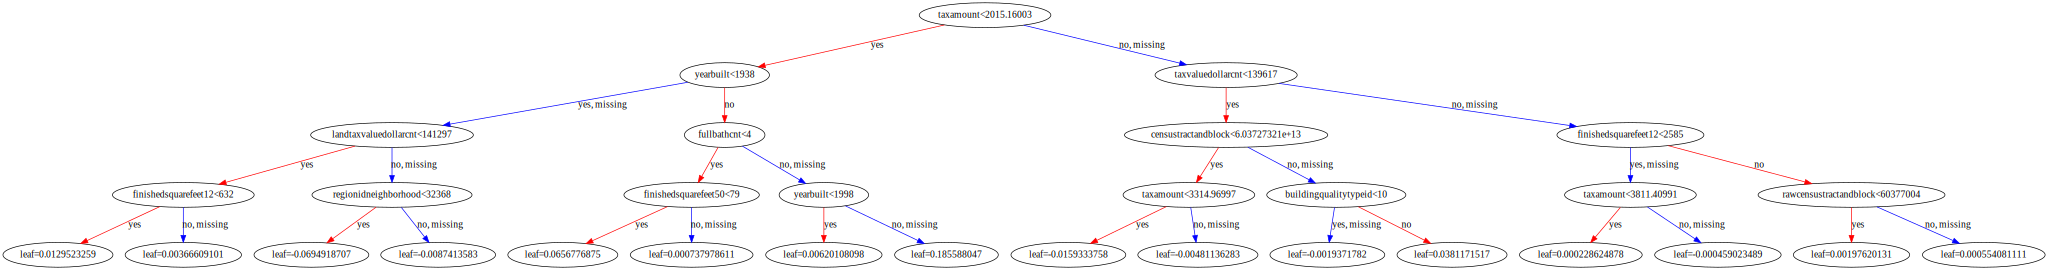

In [16]:
xgb.to_graphviz(clf, num_trees=2)